# CIFAR image classification

In this tutorial, we will demonstrate how we can use [Microsoft PyMarlin](https://github.com/microsoft/PyMarlin) library to train an image classifier.

This tutorial is based on official [PyTorch blog on Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which trains a image classifier using CIFAR data.

In [ ]:
# !pip install pymarlin

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


## Step 1. Data preprocessing

This step involves, 
1. Downloading data
2. Preprocessing it 
3. Analyzing it
4. Creating a final dataset

In pymarlin, **DataInteface** and **DataProcessor** is where you implement the code related to all the steps above.


In [ ]:
from pymarlin.core import data_interface
class CifarDataProcessor(data_interface.DataProcessor):
    def process(self):
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
        self.datasets = {'Train': trainset, 'Test': testset}
        return self.datasets

    def analyze(self):
        datasets = self.datasets
        print(f'train data size = {len(datasets["Train"])}')
        print(f'val data size = {len(datasets["Test"])}')
        print('Examples')
        sample_images = [datasets['Train'][i][0] for i in range(4)]
        self._imshow(torchvision.utils.make_grid(sample_images))
        
    def _imshow(self,img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


Files already downloaded and verified
Files already downloaded and verified
train data size = 50000
val data size = 10000
Examples


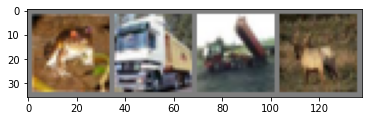

In [ ]:
dp = CifarDataProcessor()
# process_data calls both process and analyze
datasets = dp.process_data()

In [ ]:
class CifarDataInterface(data_interface.DataInterface):
    
    def __init__(self, dp:CifarDataProcessor):
        datasets = dp.process()
        self.train_ds = datasets['Train']
        self.val_ds = datasets['Test']

    @property
    def classes(self):
        return ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    def get_train_dataset(self):
        return self.train_ds
    
    def get_val_dataset(self):
        return self.val_ds 

In [ ]:
di  = CifarDataInterface(dp)

Files already downloaded and verified
Files already downloaded and verified


## Step 2. Training
We will override pymarlin's ModuleInterface and create a training recipe.

In [ ]:
# Actual model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Training recipe
from pymarlin import ModuleInterface
class CifarModule(ModuleInterface):
    '''
    ModuleInterface contains instruction to create data loader , 
    defines train step, optimizer, scheduler, evaluation etc.
    
    Just implement the abstract function: refer docstrings.
    '''
    def __init__(self, data_interface):
        super().__init__() # always initialize superclass first
        self.data_interface = data_interface
        
        self.net = Net()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        
        self.running_loss = 0.0

    def get_optimizers_schedulers(
        self, estimated_global_steps_per_epoch: int, epochs: int
        ):
        return [self.optimizer], []

    def get_train_dataloader(
        self, sampler:type, batch_size:int
        ):
        return torch.utils.data.DataLoader(self.data_interface.get_train_dataset(), batch_size=batch_size,
                                          shuffle=True)

    def get_val_dataloaders(
        self, sampler:torch.utils.data.Sampler, batch_size : int
        ): 
        return torch.utils.data.DataLoader(self.data_interface.get_val_dataset(), batch_size=batch_size,
                                         shuffle=False)

    def train_step(
        self, global_step: int, batch, device
        ):
        '''
        First output should be loss. Can return multiple outputs
        '''
        inputs, labels = batch # output of dataloader will be input of train_step
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = self.net(inputs)
        loss = self.criterion(outputs, labels)
        self.running_loss += loss.item()
        if global_step % 2000 == 0:    # print every 2000 mini-batches
            print('[%5d] loss: %.3f' %
                  (global_step, self.running_loss / 2000))
            self.running_loss = 0.0
        return loss

    def val_step(self, global_step: int, batch, device) :
        '''
        Can return multiple outputs. First output need not be loss.
        '''
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs = self.net(images)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        return correct, total

    def on_end_val_epoch(self,
        global_step: int,
        *val_step_collated_outputs,
        key='default'):
        '''
        callback after validation loop ends
        '''
        corrects, totals = val_step_collated_outputs
        correct = sum(corrects) # list of integers
        total= sum(totals)
        
        accuracy = 100 * correct / total
        print(f'Val accuracy at step {global_step} = {accuracy}%')
        

In [ ]:
module = CifarModule(di)

### Train for few steps
Check if the entire loop runs without error. Use `max_train_steps_per_epoch` and `max_val_steps_per_epoch` to stop early. Set them to `null` to train on full data.

In [ ]:
from pymarlin.core import trainer, trainer_backend
from pymarlin.utils.checkpointer.checkpoint_utils import DefaultCheckpointerArguments
backend = trainer_backend.SingleProcess()
chkp_args = DefaultCheckpointerArguments(checkpoint=False)

args = trainer.TrainerArguments(
    epochs=2,
    max_train_steps_per_epoch = 100,
    max_val_steps_per_epoch = 10,
    train_batch_size=4,
    val_batch_size=16,
    writers=[],
    log_level = 'DEBUG'
)
tr = trainer.Trainer(
    trainer_backend = backend,
    module = module,
    args = args
)
tr.train()

SystemLog: 2021-06-16 16:46:36,705:INFO : pymarlin.core.trainer : 226 : _abc_impl: <_abc_data object at 0x7f971b2f4e10>
SystemLog: 2021-06-16 16:46:36,709:INFO : pymarlin.core.trainer : 226 : args: TrainerArguments(epochs=2, use_gpu=True, train_batch_size=4, gpu_batch_size_limit=512, val_batch_size=16, max_train_steps_per_epoch=100, max_val_steps_per_epoch=10, clip_grads=True, max_grad_norm=1.0, reset_optimizers_schedulers=False, checkpointer_args=DefaultCheckpointerArguments(checkpoint=True, delete_existing_checkpoints=False, period=1, save_dir='/content/checkpoints', model_state_save_dir='/content/checkpoints', load_dir=None, load_filename=None, file_prefix='model', file_ext='pt', log_level='INFO'), distributed_training_args=DistributedTrainingArguments(local_rank=0, global_rank=0, world_size=1, backend='nccl', init_method='env://', gather_frequency=None), writers=[], stats_args=StatInitArguments(log_steps=1, update_system_stats=False, log_model_steps=1000, exclude_list='bias|LayerNo

SystemLog: 2021-06-16 16:46:36,806:INFO : pymarlin.core.trainer : 148 : Training epoch 0



SystemLog: 2021-06-16 16:46:37,823:INFO : pymarlin.core.trainer : 154 : Validating


Val accuracy at step 100 = 12.5%
SystemLog: 2021-06-16 16:46:37,985:INFO : pymarlin.core.trainer : 148 : Training epoch 1



SystemLog: 2021-06-16 16:46:38,990:INFO : pymarlin.core.trainer : 154 : Validating


Val accuracy at step 200 = 13.125%

SystemLog: 2021-06-16 16:46:39,171:INFO : pymarlin.core.trainer : 168 : Finished training .. 


In [ ]:
from pymarlin.core import trainer, trainer_backend
from pymarlin.utils.checkpointer.checkpoint_utils import DefaultCheckpointerArguments
backend = trainer_backend.SingleProcess()
chkp_args = DefaultCheckpointerArguments(checkpoint=False)

args = trainer.TrainerArguments(
    epochs=2,
    train_batch_size=4,
    val_batch_size=16,
    writers=['tensorboard'],
    clip_grads=False,
    log_level = 'INFO',
    checkpointer_args=chkp_args
)

tr = trainer.Trainer(
    trainer_backend = backend,
    module = module,
    args = args
)

tr.train()

SystemLog: 2021-06-16 16:32:04,333:INFO : pymarlin.core.trainer : 226 : _abc_impl: <_abc_data object at 0x7f971b2f4e10>
SystemLog: 2021-06-16 16:32:04,334:INFO : pymarlin.core.trainer : 226 : args: TrainerArguments(epochs=2, use_gpu=True, train_batch_size=4, gpu_batch_size_limit=512, val_batch_size=16, max_train_steps_per_epoch=None, max_val_steps_per_epoch=None, clip_grads=False, max_grad_norm=1.0, reset_optimizers_schedulers=False, checkpointer_args=DefaultCheckpointerArguments(checkpoint=False, delete_existing_checkpoints=False, period=1, save_dir='/content/checkpoints', model_state_save_dir='/content/checkpoints', load_dir=None, load_filename=None, file_prefix='model', file_ext='pt', log_level='INFO'), distributed_training_args=DistributedTrainingArguments(local_rank=0, global_rank=0, world_size=1, backend='nccl', init_method='env://', gather_frequency=None), writers=['tensorboard'], stats_args=StatInitArguments(log_steps=1, update_system_stats=False, log_model_steps=1000, exclude_

SystemLog: 2021-06-16 16:32:04,452:INFO : pymarlin.core.trainer : 148 : Training epoch 0


[ 2000] loss: 2.346
[ 4000] loss: 1.818
[ 6000] loss: 1.653
[ 8000] loss: 1.559
[10000] loss: 1.510
[12000] loss: 1.444

SystemLog: 2021-06-16 16:33:57,180:INFO : pymarlin.core.trainer : 154 : Validating



Val accuracy at step 12500 = 48.54%
SystemLog: 2021-06-16 16:34:00,718:INFO : pymarlin.core.trainer : 148 : Training epoch 1


[14000] loss: 1.426
[16000] loss: 1.363
[18000] loss: 1.342
[20000] loss: 1.314
[22000] loss: 1.306
[24000] loss: 1.292

SystemLog: 2021-06-16 16:35:56,793:INFO : pymarlin.core.trainer : 154 : Validating



Val accuracy at step 25000 = 53.07%

SystemLog: 2021-06-16 16:36:00,478:INFO : pymarlin.core.trainer : 168 : Finished training .. 


## Step 3. Saving the model

In [ ]:
PATH = './cifar_net.pth'
torch.save(module.net.state_dict(), PATH)